<a href="https://colab.research.google.com/github/jdasam/ant5015/blob/main/notebooks/3rd_week_note_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
from pathlib import Path

import torch
import torchaudio


In [2]:
'''
Let's only use testset
'''
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
# !는 주피터에서 터미널 명령어를 사용할때 붙임
# python이 아닌 OS (Linux)에 명령을 내리고 싶을 때 실행


--2024-03-18 04:56:50--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|74.125.200.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz’

nsynth-test.jsonwav 100%[===================>] 333.31M  23.0MB/s    in 16s     

2024-03-18 04:57:08 (20.7 MB/s) - ‘nsynth-test.jsonwav.tar.gz’ saved [349501546/349501546]



In [3]:
# 압축 풀기
!tar -xf nsynth-test.jsonwav.tar.gz

In [4]:
meta = json.load(open('nsynth-test/examples.json'))
len(meta)

4096

In [7]:
# 데이터셋이 어떻게 구성돼있는지 보기
list(meta.keys())[:5]

['bass_synthetic_068-049-025',
 'keyboard_electronic_001-021-127',
 'guitar_acoustic_010-066-100',
 'reed_acoustic_037-068-127',
 'flute_acoustic_002-077-100']

In [8]:
meta['bass_synthetic_068-049-025']

{'qualities': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'pitch': 49,
 'note': 217499,
 'instrument_source_str': 'synthetic',
 'velocity': 25,
 'instrument_str': 'bass_synthetic_068',
 'instrument': 656,
 'sample_rate': 16000,
 'qualities_str': ['dark'],
 'instrument_source': 2,
 'note_str': 'bass_synthetic_068-049-025',
 'instrument_family': 0,
 'instrument_family_str': 'bass'}

In [9]:
# 메타의 키 이름이 파일 이름
fn = 'bass_synthetic_068-049-025' + '.wav'
audio_dir = Path('/content/nsynth-test/audio')

# audio directory 가 존재하는지 확인
audio_dir.exists()

True

In [11]:
audio_fn = audio_dir / fn
audio_fn, audio_fn.exists()

(PosixPath('/content/nsynth-test/audio/bass_synthetic_068-049-025.wav'), True)

In [12]:
import IPython.display as ipd

y, sr = torchaudio.load(audio_fn) # torchaudio.laod returns (wavesamples, sampling_rate)
ipd.Audio(y, rate=sr)

In [15]:
# check metadata and file consistency

fns = sorted(list(meta.keys()))
fns[:10]

['bass_electronic_018-022-100',
 'bass_electronic_018-023-025',
 'bass_electronic_018-023-075',
 'bass_electronic_018-023-127',
 'bass_electronic_018-024-025',
 'bass_electronic_018-024-100',
 'bass_electronic_018-026-025',
 'bass_electronic_018-026-075',
 'bass_electronic_018-026-127',
 'bass_electronic_018-027-075']

In [22]:
# !mv nsynth-test/audio/bass_electronic_018-026-127.wav nsynth-test/
!mv nsynth-test/bass_electronic_018-026-127.wav nsynth-test/audio/

In [23]:
# for every filename, check the file exists
for fn in fns:
  does_exist = (audio_dir / fn).with_suffix('.wav').exists()
  assert does_exist, f"{fn} does not exist"

In [25]:
# Convert audio to spectrogram
y.shape # [1, T] . SR: 16000, Duration: 4

torch.Size([1, 64000])

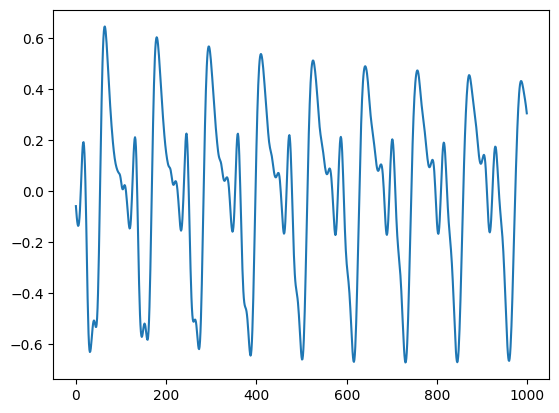

In [27]:
import matplotlib.pyplot as plt
plt.plot(y[0, 1000:2000]) # If you select single value in sepcific dimension, that dimension disappears

In [44]:
# Convert waveform to spectrogram using torchaudio

spec_converter = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=512)

spec = spec_converter(y)

In [45]:
spec.shape # num channel of input x num frequency bin x num time bin
# num frequency bin = n_fft // 2 + 1


torch.Size([1, 513, 126])

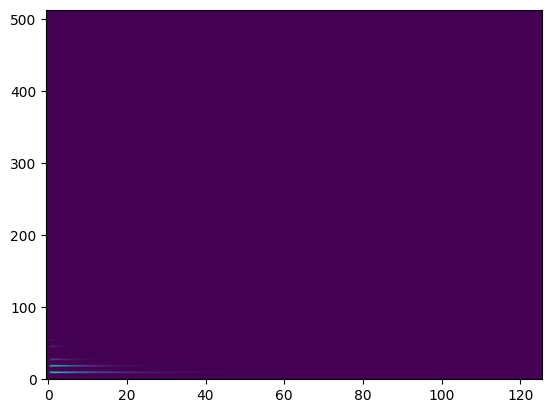

In [46]:
plt.imshow(spec[0], aspect='auto', origin='lower')

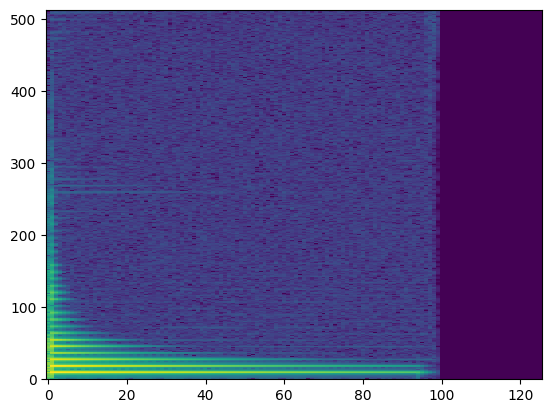

In [47]:
db_converter = torchaudio.transforms.AmplitudeToDB()
db_spec = db_converter(spec)
plt.imshow(db_spec[0], aspect='auto', origin='lower', interpolation='none')

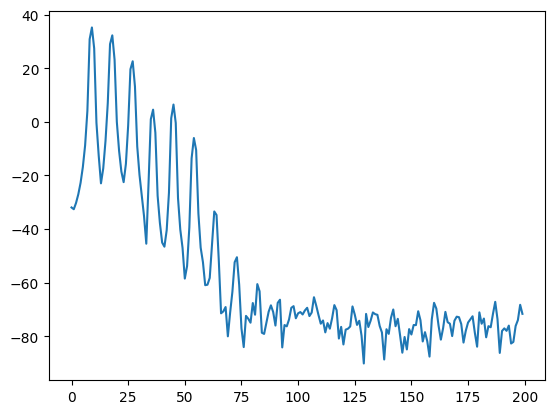

In [50]:
time_idx = 10
spectrum = db_spec[0, :200, time_idx] # select 0th channel, all frequency, time-idx-th time frame
plt.plot(spectrum)

torch.Size([513, 40])


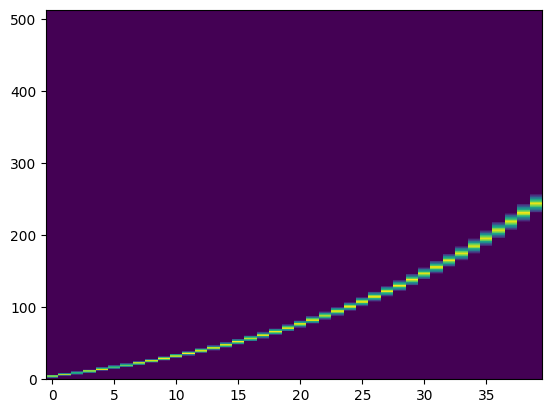

In [58]:
# compress frequency scale to log scale
mel_scale = torchaudio.transforms.MelScale(n_mels=40, sample_rate=16000, f_min=20, f_max=4000, n_stft=513)

print(mel_scale.fb.shape)
plt.imshow(mel_scale.fb, aspect='auto', origin='lower', interpolation='none')

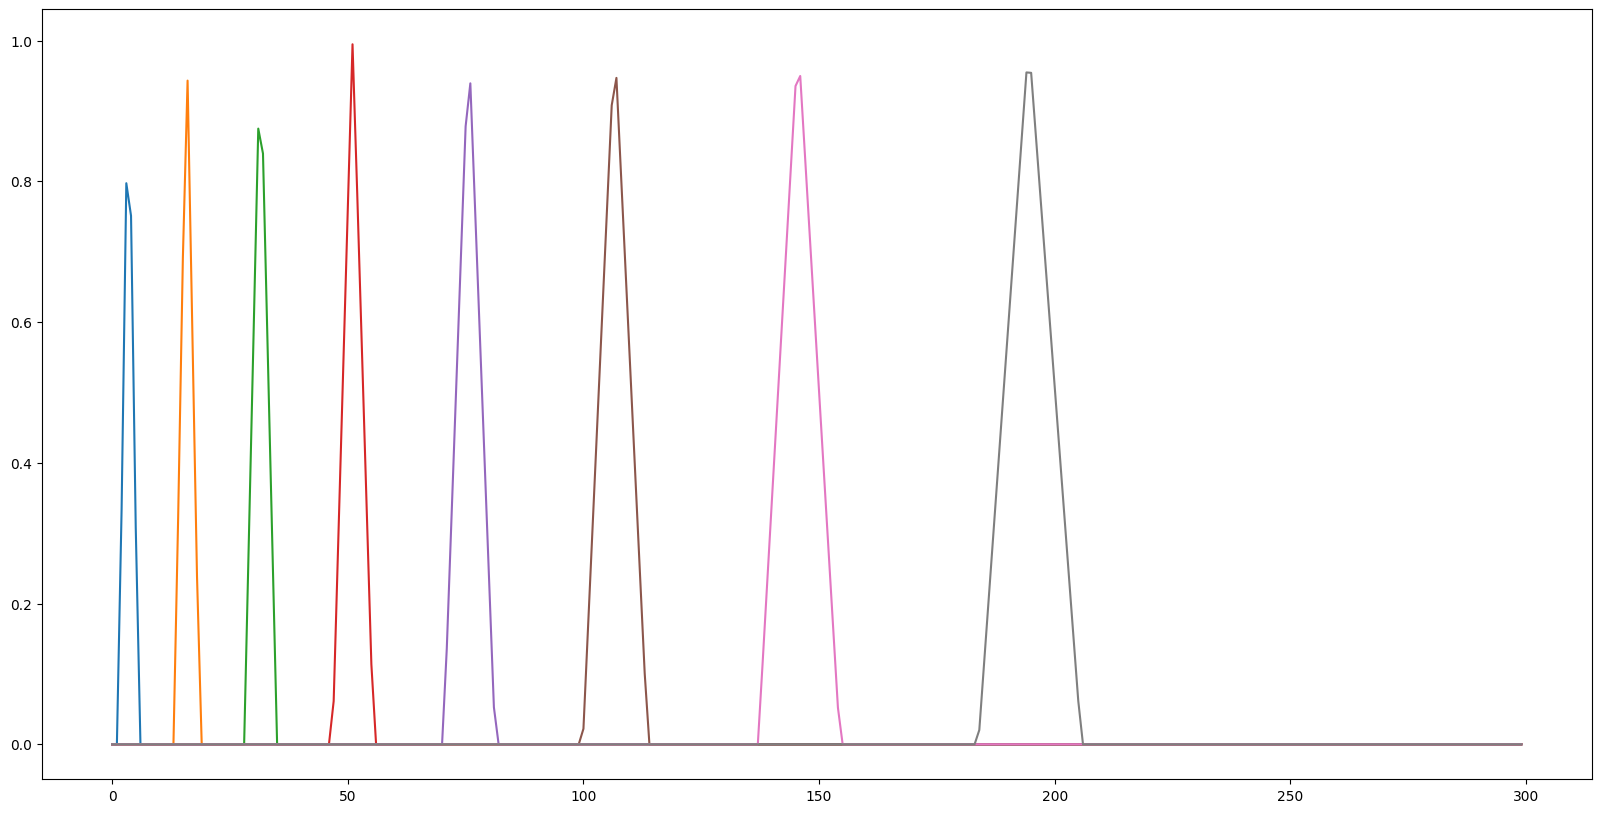

In [61]:
plt.figure(figsize=(20, 10))

for i in range(0, mel_scale.fb.shape[1], 5):
  plt.plot(mel_scale.fb[:300, i])



In [65]:
mel_spec = torch.mm(mel_scale.fb.T, spec[0])
spec.shape, mel_scale.fb.shape, mel_spec.shape

(torch.Size([1, 513, 126]), torch.Size([513, 40]), torch.Size([40, 126]))